In [43]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from collections import defaultdict
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# Configuration
BASE_DIR = "D:/HAM/data"
IMG_DIR = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "GroundTruth.csv")
IMG_SIZE = 224
QUALITY_THRESHOLD = 0.8  # Minimum quality score (0-1)
MIN_SAMPLES = 50  # Minimum samples per class after balancing

In [44]:
# Load and prepare metadata
df = pd.read_csv(CSV_PATH)
df['image_path'] = df['image'].apply(lambda x: os.path.join(IMG_DIR, x + ".jpg"))
label_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [47]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced classes
# Assuming 'label_cols' column contains the class labels (adjust if your label column is different)
if 'label_cols' in df.columns:
    classes = np.unique(df['label_cols'])
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=df['label_cols']
    )
    class_weight_dict = dict(zip(classes, class_weights))
    print("Class weights:", class_weight_dict)
else:
    print("Label column 'label_cols' not found in dataframe.")
# ...existing code...

Label column 'label_cols' not found in dataframe.


In [48]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming df and label_cols are already defined as in your code

# Calculate class weights
class_counts = df[label_cols].sum(axis=0)  # Count of positive samples for each class
total_samples = len(df)  # Total number of samples

# Method 1: Inverse of class frequency (balanced weights)
class_weights = {}
for i, class_name in enumerate(label_cols):
    class_weights[i] = total_samples / (len(label_cols) * class_counts[class_name])

# Method 2: Using sklearn's compute_class_weight (for binary classification per class)
class_weights_list = []
for class_name in label_cols:
    y = df[class_name]
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights_list.append(weights[1])  # Take weight for positive class

class_weights = dict(enumerate(class_weights_list))

# Method 3: For multi-label with more sophisticated weighting
def calculate_class_weights(df, label_cols, method='balanced'):
    class_weights = {}
    n_classes = len(label_cols)
    total_samples = len(df)
    
    for i, class_name in enumerate(label_cols):
        positive_count = df[class_name].sum()
        negative_count = total_samples - positive_count
        
        if method == 'balanced':
            weight_for_positive = total_samples / (2 * positive_count)
            weight_for_negative = total_samples / (2 * negative_count)
        elif method == 'inverse':
            weight_for_positive = negative_count / positive_count
            weight_for_negative = 1.0
        else:  # uniform
            weight_for_positive = 1.0
            weight_for_negative = 1.0
            
        class_weights[i] = {0: weight_for_negative, 1: weight_for_positive}
    
    return class_weights

# Usage
class_weights = calculate_class_weights(df, label_cols, method='balanced')

In [49]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def preprocess_image_keras(image_path, target_size=(224, 224), normalize="imagenet"):
    img = image.load_img(image_path, target_size=target_size)
    img = image.img_to_array(img)
    
    if normalize == "0-1":
        img = img / 255.0
    elif normalize == "imagenet":
        img = preprocess_input(img)  # Handles ImageNet normalization
    
    return img

In [50]:
label_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
y = df[label_cols].values.astype(np.float32)  # Shape: (n_samples, n_classes)

In [55]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

# Convert data to proper numpy arrays
X = np.array(df['image_path'].values).reshape(-1, 1)  # Reshape to (n_samples, 1)
y = df[label_cols].values

# First split: 70% train, 30% temp
X_train, y_train, X_temp, y_temp = iterative_train_test_split(
    X, y, test_size=0.3
)

# Second split: 15% val, 15% test
X_val, y_val, X_test, y_test = iterative_train_test_split(
    X_temp, y_temp, test_size=0.5
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 7011, Val: 1503, Test: 1501


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os


# --- 3. Custom Dataset Class ---
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths.squeeze()  # Remove extra dimension
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), torch.tensor(self.labels[idx], dtype=torch.float32)

# --- 4. Model Definition ---
def get_model(name='resnet50', num_classes=7):
    model = getattr(models, name)(pretrained=True)
    
    if 'resnet' in name:
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, num_classes),
            nn.Sigmoid()
        )
    elif 'efficientnet' in name:
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, num_classes),
            nn.Sigmoid()
        )
    elif 'densenet' in name:
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier.in_features, num_classes),
            nn.Sigmoid()
        )
    return model

# --- 5. Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights (critical for imbalance)
class_weights = torch.tensor(
    len(y_train) / (len(label_cols) * y_train.sum(axis=0)),
    dtype=torch.float32
).to(device)

# Initialize
model = get_model('resnet50', len(label_cols)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)  # Handles class imbalance

# DataLoaders
train_loader = DataLoader(
    SkinLesionDataset(X_train, y_train),
    batch_size=32, shuffle=True
)
val_loader = DataLoader(
    SkinLesionDataset(X_val, y_val),
    batch_size=32
)

# --- 6. Training Loop ---
for epoch in range(20):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, labels in val_loader:
            outputs = model(images.to(device))
            val_loss += criterion(outputs, labels.to(device)).item()
    
    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss/len(val_loader):.4f}")

# --- 7. Save Model ---
torch.save(model.state_dict(), 'skin_lesion_model.pth')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


Epoch 1: Train Loss = 0.6150, Val Loss = 0.6828
Epoch 2: Train Loss = 1.0367, Val Loss = 0.6738
Epoch 3: Train Loss = 0.6460, Val Loss = 0.6718
Epoch 4: Train Loss = 0.6116, Val Loss = 0.6712
Epoch 5: Train Loss = 0.7180, Val Loss = 0.6729
Epoch 6: Train Loss = 0.6103, Val Loss = 0.6716
Epoch 7: Train Loss = 0.6434, Val Loss = 0.6692
Epoch 8: Train Loss = 0.6289, Val Loss = 0.6664
Epoch 9: Train Loss = 0.6362, Val Loss = 0.6667
Epoch 10: Train Loss = 0.6233, Val Loss = 0.6659
Epoch 11: Train Loss = 0.6119, Val Loss = 0.6690
Epoch 12: Train Loss = 0.8926, Val Loss = 0.6660
Epoch 13: Train Loss = 0.6202, Val Loss = 0.6688
Epoch 14: Train Loss = 0.6060, Val Loss = 0.6687
Epoch 15: Train Loss = 0.6082, Val Loss = 0.6697
Epoch 16: Train Loss = 0.6188, Val Loss = 0.6686
Epoch 17: Train Loss = 0.6198, Val Loss = 0.6712
Epoch 18: Train Loss = 0.6048, Val Loss = 0.6696
Epoch 19: Train Loss = 0.6082, Val Loss = 0.6684
Epoch 20: Train Loss = 0.6201, Val Loss = 0.6687



Test Set Metrics:
Accuracy: 0.0113
Precision (macro): 0.1601
Recall (macro): 0.9911
F1-score (macro): 0.2277

Per-class Metrics:

Class: MEL
Precision: 0.1541
Recall: 0.9581
F1-score: 0.2656


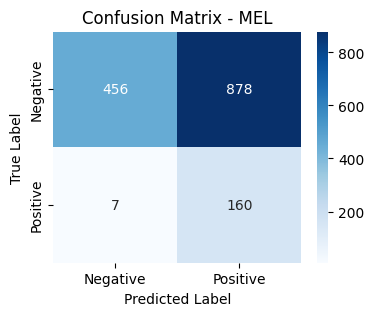


Class: NV
Precision: 0.6768
Recall: 1.0000
F1-score: 0.8072


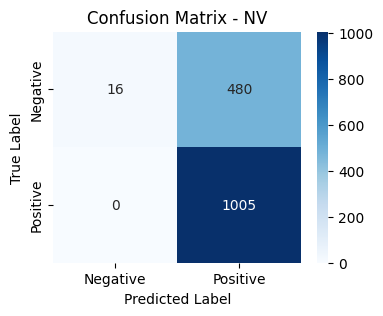


Class: BCC
Precision: 0.0575
Recall: 1.0000
F1-score: 0.1087


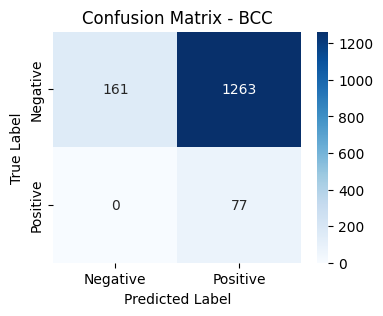


Class: AKIEC
Precision: 0.0351
Recall: 0.9796
F1-score: 0.0678


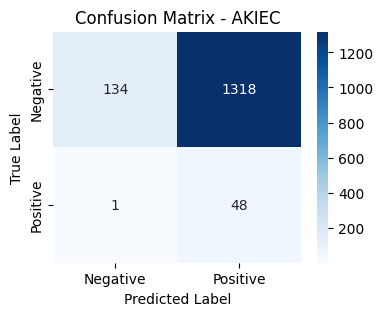


Class: BKL
Precision: 0.1712
Recall: 1.0000
F1-score: 0.2923


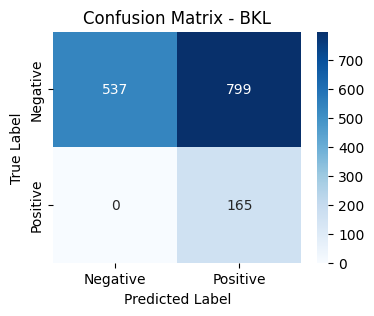


Class: DF
Precision: 0.0122
Recall: 1.0000
F1-score: 0.0241


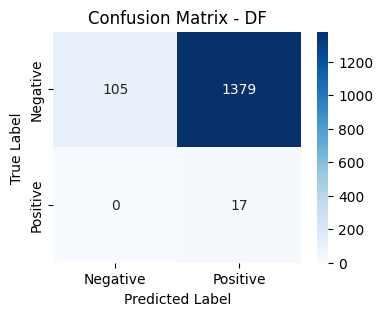


Class: VASC
Precision: 0.0142
Recall: 1.0000
F1-score: 0.0279


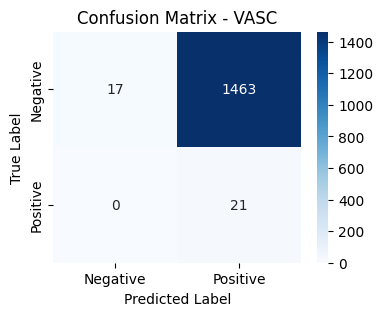

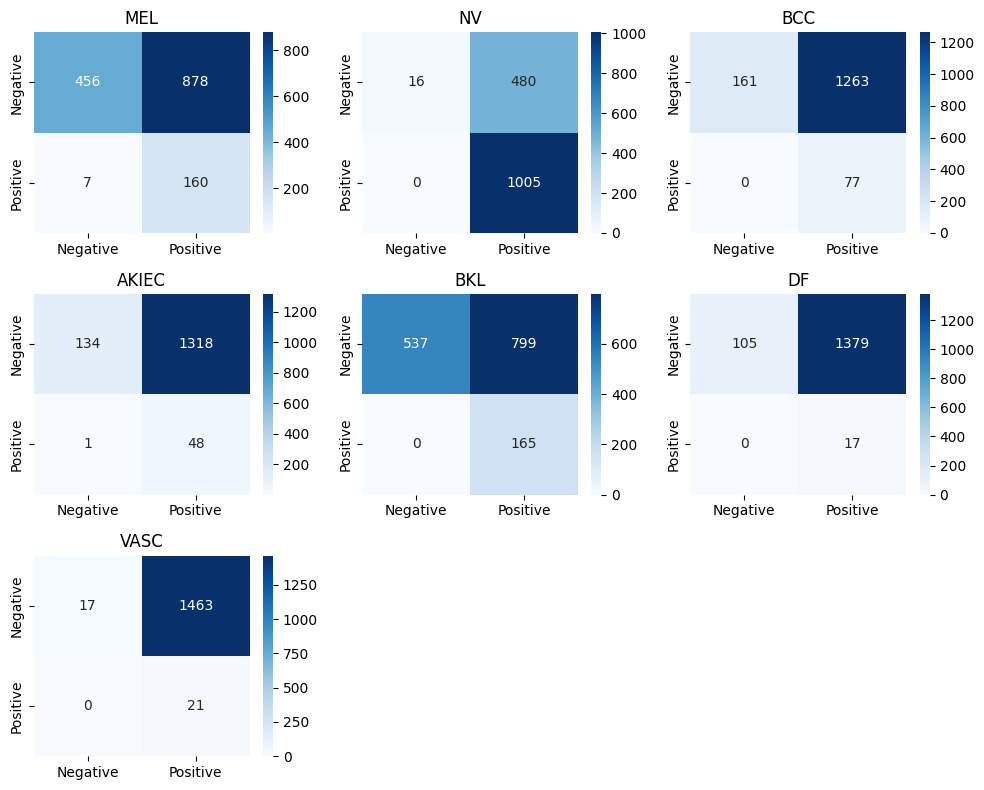

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, multilabel_confusion_matrix)
from sklearn.preprocessing import MultiLabelBinarizer  # Added this import

# 1. Load the trained model
model = get_model('resnet50', len(label_cols)).to(device)
model.load_state_dict(torch.load('skin_lesion_model.pth'))
model.eval()

# 2. Prepare test dataset
test_dataset = SkinLesionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Evaluation function
def evaluate_model(model, test_loader, threshold=0.5):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
    
    return np.concatenate(all_labels), np.concatenate(all_preds)

# 4. Run evaluation
y_true, y_pred = evaluate_model(model, test_loader)

# 5. Calculate metrics
print("\nTest Set Metrics:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")

# 6. Per-class metrics
print("\nPer-class Metrics:")
print("="*50)
for i, class_name in enumerate(label_cols):
    print(f"\nClass: {class_name}")
    print(f"Precision: {precision_score(y_true[:, i], y_pred[:, i]):.4f}")
    print(f"Recall: {recall_score(y_true[:, i], y_pred[:, i]):.4f}")
    print(f"F1-score: {f1_score(y_true[:, i], y_pred[:, i]):.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {class_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 7. Multi-label confusion matrix
plt.figure(figsize=(10, 8))
cm = multilabel_confusion_matrix(y_true, y_pred)
for i, (matrix, class_name) in enumerate(zip(cm, label_cols)):
    plt.subplot(3, 3, i+1)  # Adjust grid based on number of classes
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(class_name)
plt.tight_layout()
plt.show()